In [15]:
!pip install fastf1
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.makedirs('./f1_cache', exist_ok=True)
fastf1.Cache.enable_cache('./f1_cache')

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loaded 22 races for 2023: ['Bahrain Grand Prix', 'Saudi Arabian Grand Prix', 'Australian Grand Prix', 'Azerbaijan Grand Prix', 'Miami Grand Prix', 'Monaco Grand Prix', 'Spanish Grand Prix', 'Canadian Grand Prix', 'Austrian Grand Prix', 'British Grand Prix', 'Hungarian Grand Prix', 'Belgian Grand Prix', 'Dutch Grand Prix', 'Italian Grand Prix', 'Singapore Grand Prix', 'Japanese Grand Prix', 'Qatar Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'São Paulo Grand Prix', 'Las Vegas Grand Prix', 'Abu Dhabi Grand Prix']


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


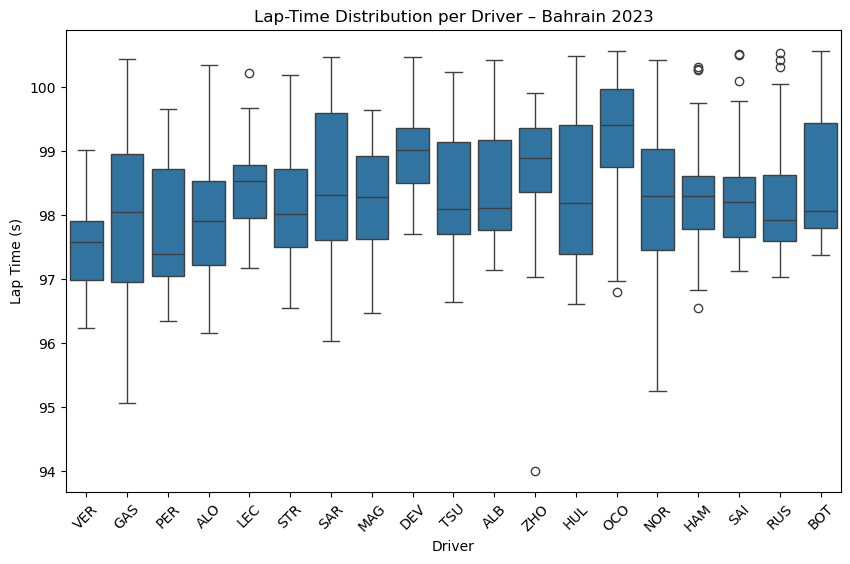

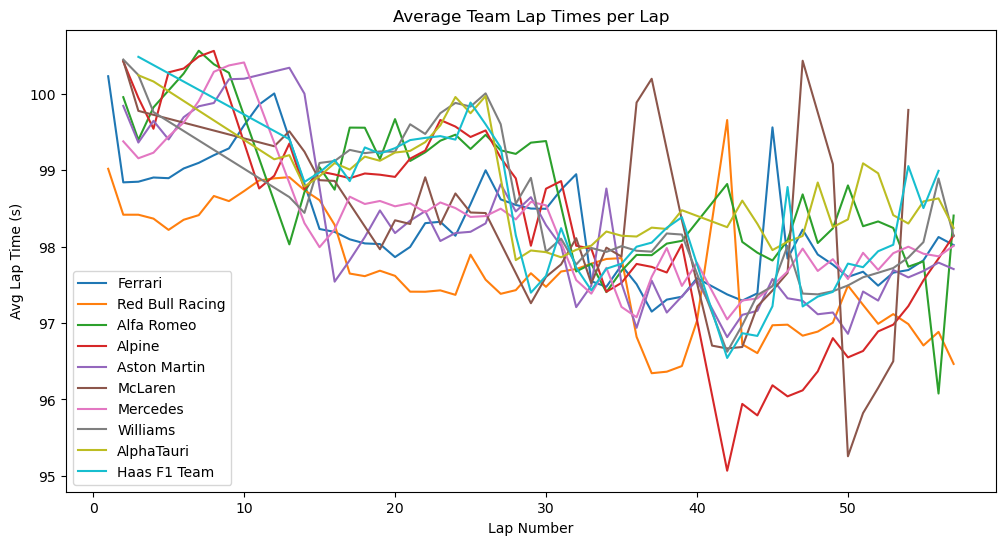

/var/folders/5n/zn66j5f978b98ng5dwj9g33c0000gn/T/ipykernel_76817/4209158768.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stints['LapTime'] = stints['LapTime'].dt.total_seconds()


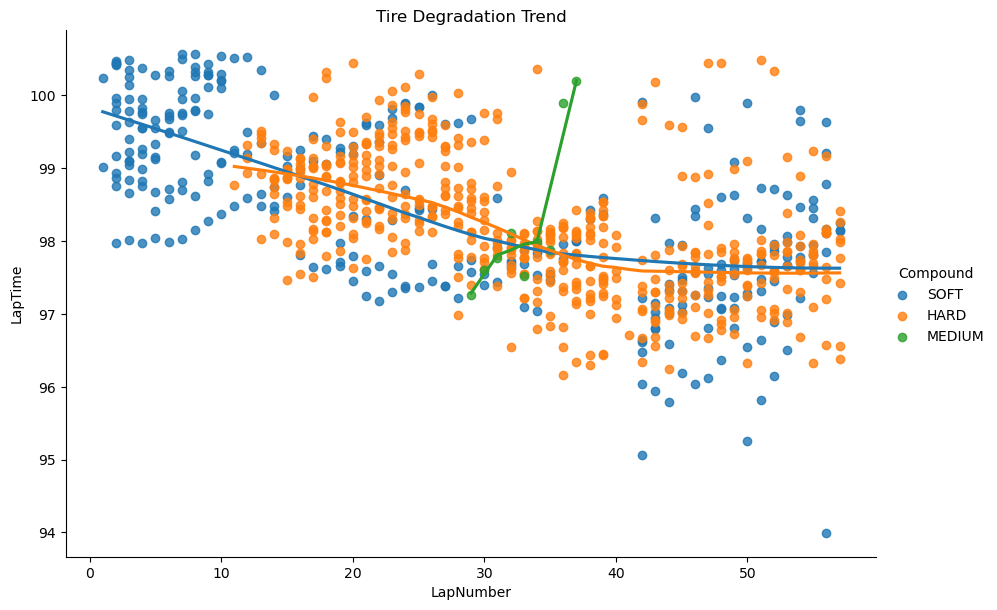

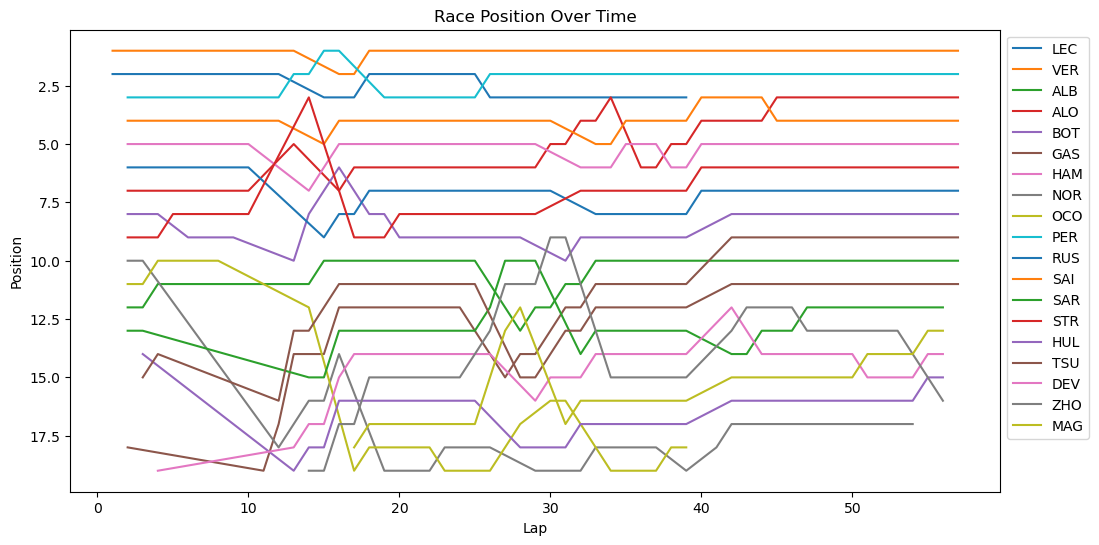

/opt/anaconda3/lib/python3.13/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/opt/anaconda3/lib/python3.13/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


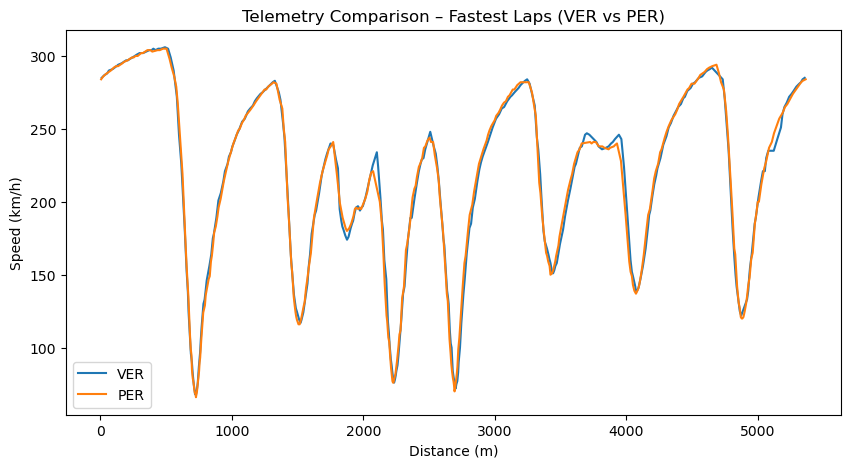


Driver Lap-Time Consistency (Std Dev s):
Driver
VER    0.635656
LEC    0.699007
DEV    0.741515
MAG    0.845242
SAI    0.850177
HAM    0.850234
ALB    0.888628
RUS    0.891130
PER    0.929605
TSU    0.929622
STR    0.966781
BOT    1.004541
ZHO    1.030122
SAR    1.112156
HUL    1.136663
ALO    1.139219
OCO    1.144629
GAS    1.230911
NOR    1.280582
Name: LapTime, dtype: float64


In [16]:
# ============================================================
# PART 1 — RACE DYNAMICS
# ============================================================

season = 2023
events = fastf1.get_event_schedule(season)
race_names = events.loc[events['EventFormat'] != 'testing', 'EventName'].tolist()
print(f"Loaded {len(race_names)} races for {season}: {race_names}")

# Example: 2023 Bahrain GP
session = fastf1.get_session(season, 'Bahrain', 'R')
session.load()
laps = session.laps.pick_quicklaps().reset_index(drop=True)

# --- Lap-time distribution ---
plt.figure(figsize=(10,6))
sns.boxplot(data=laps, x='Driver', y=laps['LapTime'].dt.total_seconds())
plt.xticks(rotation=45)
plt.title('Lap-Time Distribution per Driver – Bahrain 2023')
plt.ylabel('Lap Time (s)')
plt.show()

# --- Team pace evolution ---
avg_team = (laps.groupby(['LapNumber','Team'])['LapTime']
            .mean().dt.total_seconds().reset_index())
plt.figure(figsize=(12,6))
for team in avg_team['Team'].unique():
    d = avg_team[avg_team['Team']==team]
    plt.plot(d['LapNumber'], d['LapTime'], label=team)
plt.legend()
plt.title('Average Team Lap Times per Lap')
plt.xlabel('Lap Number'); plt.ylabel('Avg Lap Time (s)')
plt.show()

# --- Tire degradation ---
stints = laps[['Driver','Stint','Compound','LapNumber','LapTime']]
stints['LapTime'] = stints['LapTime'].dt.total_seconds()
sns.lmplot(data=stints, x='LapNumber', y='LapTime', hue='Compound',
           height=6, aspect=1.5, lowess=True)
plt.title('Tire Degradation Trend'); plt.show()

# --- Position evolution ---
pos = laps.groupby(['LapNumber','Driver'])['Position'].mean().reset_index()
plt.figure(figsize=(12,6))
for d in pos['Driver'].unique():
    plt.plot(pos[pos['Driver']==d]['LapNumber'], pos[pos['Driver']==d]['Position'], label=d)
plt.gca().invert_yaxis()
plt.xlabel('Lap'); plt.ylabel('Position')
plt.title('Race Position Over Time')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# --- Fastest-lap telemetry comparison (VER vs PER) ---
ver = session.laps.pick_driver('VER').pick_fastest()
per = session.laps.pick_driver('PER').pick_fastest()
tel_ver = ver.get_car_data().add_distance()
tel_per = per.get_car_data().add_distance()

plt.figure(figsize=(10,5))
plt.plot(tel_ver['Distance'], tel_ver['Speed'], label='VER')
plt.plot(tel_per['Distance'], tel_per['Speed'], label='PER')
plt.xlabel('Distance (m)'); plt.ylabel('Speed (km/h)')
plt.title('Telemetry Comparison – Fastest Laps (VER vs PER)')
plt.legend(); plt.show()

# --- Driver consistency metric ---
driver_consistency = (laps.groupby('Driver')['LapTime']
                      .apply(lambda x: x.dt.total_seconds().std())
                      .sort_values())
print("\nDriver Lap-Time Consistency (Std Dev s):")
print(driver_consistency)


Driver Performance Summary:
   Driver    MeanLap  BestLap  Consistency  NumLaps  AvgPosition  PaceIndex  \
18    ZHO  98.711568   93.996     1.030122       37    13.864865   0.952229   
4     GAS  97.946864   95.068     1.230911       44    11.477273   0.970608   
9     NOR  98.193211   95.257     1.280582       38    17.263158   0.970098   
14    SAR  98.491049   96.037     1.112156       41    12.682927   0.975084   
1     ALO  98.073560   96.156     1.139219       50     5.020000   0.980448   

    ConsistencyScore  
18          0.492581  
4           0.448247  
9           0.438485  
14          0.473450  
1           0.467460  


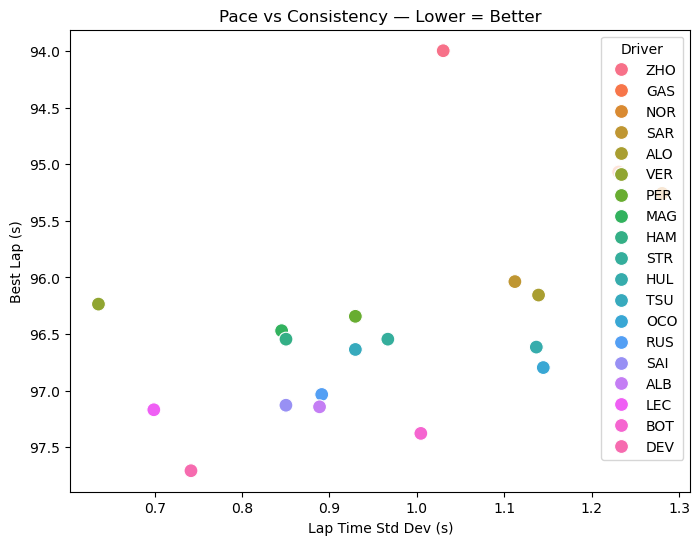

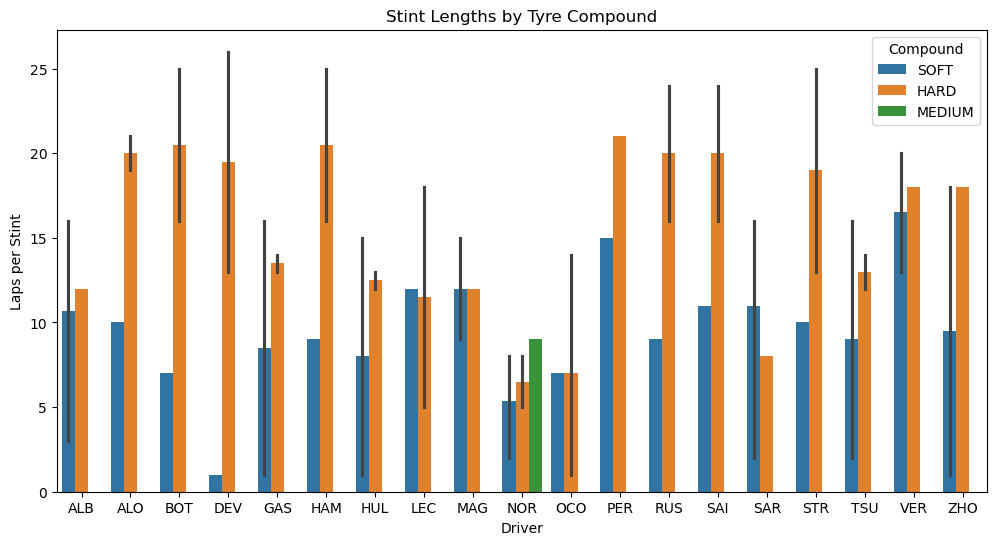

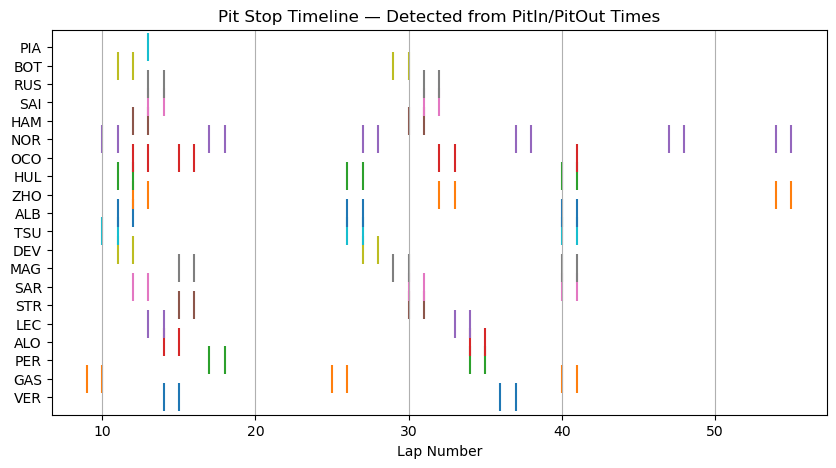

/opt/anaconda3/lib/python3.13/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


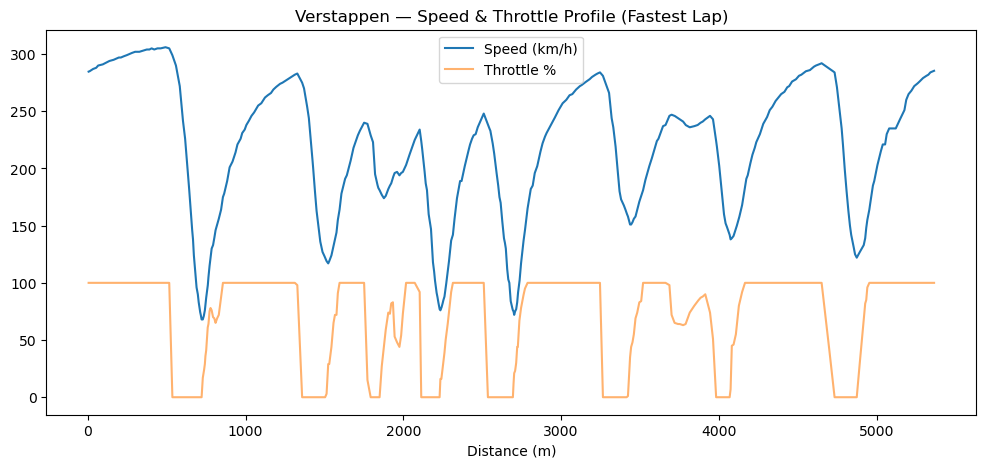


Composite Driver Index (Higher = Better):
   Driver  CompositeScore  BestLap  Consistency  AvgPosition
17    VER        0.381061   96.236     0.635656     1.039216
7     LEC        0.264072   97.170     0.699007     2.428571
11    PER        0.247103   96.344     0.929605     2.313725
13    SAI        0.217541   97.130     0.850177     3.980392
5     HAM        0.206080   96.546     0.850234     5.160000
12    RUS        0.192194   97.035     0.891130     7.040816
3     DEV        0.191127   97.709     0.741515    14.550000
15    STR        0.185701   96.546     0.966781     7.145833
1     ALO        0.185279   96.156     1.139219     5.020000
0     ALB        0.183291   97.144     0.888628    10.363636
8     MAG        0.180713   96.471     0.845242    15.444444
2     BOT        0.178498   97.379     1.004541     8.437500
16    TSU        0.177471   96.637     0.929622    11.886364
18    ZHO        0.167519   93.996     1.030122    13.864865
14    SAR        0.163010   96.037     1.1

In [ ]:
# ============================================================
# PART 2 — Driver Performance & Race Strategy Analysis
# ============================================================

import numpy as np

# --- Compute driver-level metrics ---
def driver_performance_summary(laps):
    df = laps.copy()
    df['LapTime_s'] = df['LapTime'].dt.total_seconds()
    summary = (
        df.groupby('Driver')
        .agg(
            MeanLap=('LapTime_s', 'mean'),
            BestLap=('LapTime_s', 'min'),
            Consistency=('LapTime_s', 'std'),
            NumLaps=('LapNumber', 'count'),
            AvgPosition=('Position', 'mean')
        )
        .reset_index()
    )
    summary['PaceIndex'] = summary['BestLap'] / summary['MeanLap']
    summary['ConsistencyScore'] = 1 / (1 + summary['Consistency'])
    return summary.sort_values('BestLap')

perf = driver_performance_summary(laps)
print("\nDriver Performance Summary:")
print(perf.head())

# --- Visualize pace vs consistency ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=perf, x='Consistency', y='BestLap', hue='Driver', s=100)
plt.gca().invert_yaxis()
plt.title('Pace vs Consistency — Lower = Better')
plt.xlabel('Lap Time Std Dev (s)')
plt.ylabel('Best Lap (s)')
plt.show()

# --- Tire strategy overview ---
stints_summary = (
    laps.groupby(['Driver','Stint','Compound'])
    .agg(
        AvgLap=('LapTime', lambda x: x.dt.total_seconds().mean()),
        Laps=('LapNumber','count')
    )
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(data=stints_summary, x='Driver', y='Laps', hue='Compound')
plt.title('Stint Lengths by Tire Compound')
plt.ylabel('Laps per Stint')
plt.show()

# --- Pit stop timeline ---
laps_df = session.laps.copy()

# Filter only laps where the car entered or exited the pits
pits = laps_df[laps_df['PitOutTime'].notna() | laps_df['PitInTime'].notna()]

plt.figure(figsize=(10, 5))
for drv in pits['Driver'].unique():
    drv_pits = pits[pits['Driver'] == drv]
    plt.scatter(drv_pits['LapNumber'], [drv]*len(drv_pits), marker='|', s=400)

plt.xlabel('Lap Number')
plt.title('Pit Stop Timeline — Detected from PitIn/PitOut Times')
plt.grid(True, axis='x')
plt.show()


# --- Sector telemetry averages ---

ver_tel = session.laps.pick_driver('VER').pick_fastest().get_telemetry()
ver_tel['DistanceDelta'] = ver_tel['Distance'].diff()
ver_tel['Accel'] = ver_tel['Speed'].diff() / ver_tel['DistanceDelta']
ver_tel = ver_tel.replace([np.inf, -np.inf], np.nan).dropna(subset=['Accel'])

plt.figure(figsize=(12,5))
plt.plot(ver_tel['Distance'], ver_tel['Speed'], label='Speed (km/h)')
plt.plot(ver_tel['Distance'], ver_tel['Throttle'], label='Throttle %', alpha=0.6)
plt.title('Verstappen — Speed & Throttle Profile (Fastest Lap)')
plt.xlabel('Distance (m)')
plt.legend()
plt.show()

# --- 6️⃣ Composite driver index ---
perf['CompositeScore'] = (
    0.5 * (1 / perf['BestLap']) +
    0.3 * perf['ConsistencyScore'] +
    0.2 * (1 / perf['AvgPosition'])
)
perf = perf.sort_values('CompositeScore', ascending=False)
print("\nComposite Driver Index (Higher = Better):")
print(perf[['Driver','CompositeScore','BestLap','Consistency','AvgPosition']])
